The purpose of the analysis is to find out:

whether the background influences decision-making, and where the model “looks",
for this we use a model that was trained on data with a background. I used trained model on 40 images to make it faster to analise images.

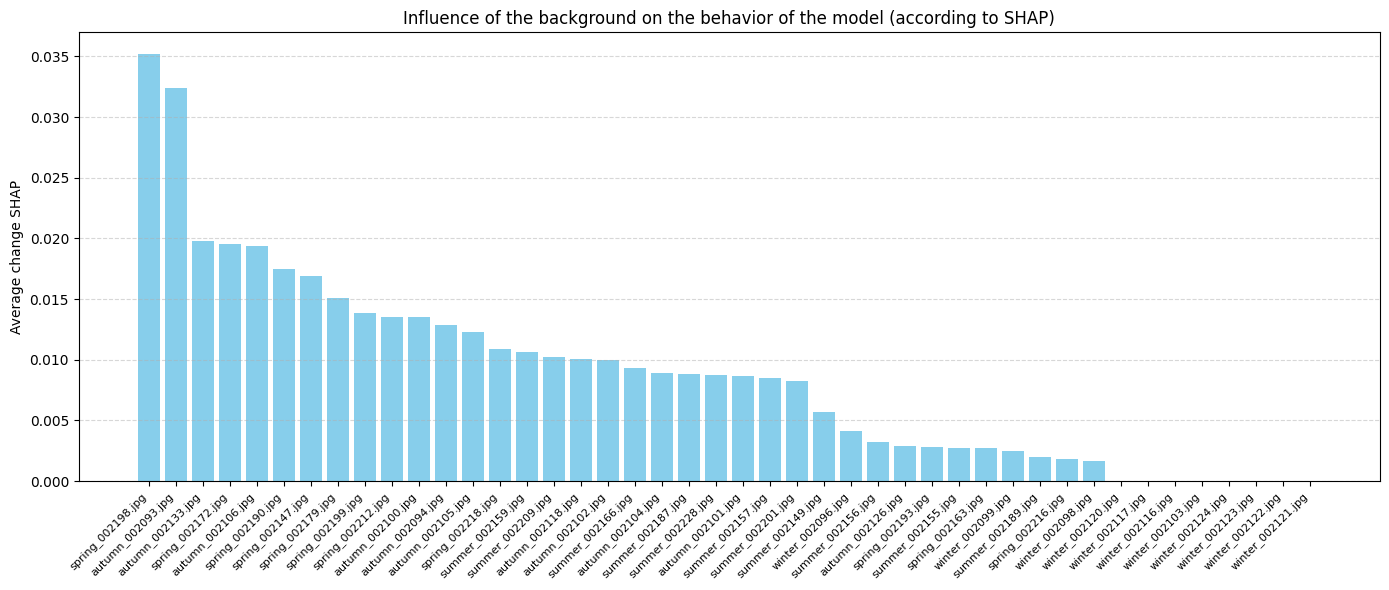

In [1]:
import os
import shap
import joblib
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_PATH = 'rf_model_40images.pkl'
IMG_SIZE = 224

model = joblib.load(MODEL_PATH)  

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

def load_images_from_folder(folder):
    images = []
    paths = []
    for filename in os.listdir(folder):
            path = os.path.join(folder, filename)
            image = Image.open(path).convert("RGB")
            image = transform(image)
            image = image.view(-1) 
            images.append(image.numpy())
            paths.append(path)
    return np.stack(images), paths

# Load data
original_images, original_paths = load_images_from_folder("with_back_40")
bg_removed_images, bg_removed_paths = load_images_from_folder("without_back_analysis")

# SHAP model
explainer = shap.TreeExplainer(model)

# SHAP values
shap_values_original = explainer.shap_values(original_images)
shap_values_nobg = explainer.shap_values(bg_removed_images)

# Comparison SHAP
diffs = []
for i in range(len(original_images)): 
    diff = np.abs(shap_values_original[0][i] - shap_values_nobg[0][i])
    diffs.append(diff.mean())

# Visualization
import matplotlib.pyplot as plt
import os

short_names = [os.path.basename(p) for p in original_paths]
sorted_indices = np.argsort(diffs)[::-1]
sorted_diffs = [diffs[i] for i in sorted_indices]
sorted_names = [short_names[i] for i in sorted_indices]

plt.figure(figsize=(14, 6))
plt.bar(range(len(sorted_diffs)), sorted_diffs, color="skyblue")
plt.xticks(range(len(sorted_diffs)), sorted_names, rotation=45, ha="right", fontsize=8)
plt.ylabel("Average change SHAP")
plt.title("Influence of the background on the behavior of the model (according to SHAP)")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


If the value is > 0.5, the background has a strong effect (the model is "distracted" by the background).

If ~0.1–0.3, the effect is moderate.

If < 0.1, the background is almost unimportant.

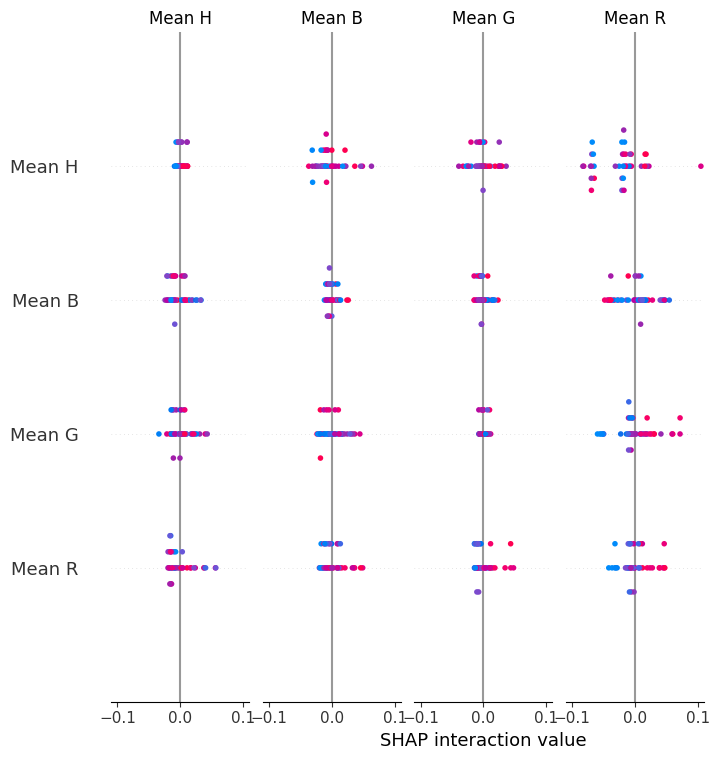

ValueError: x and y must be the same size

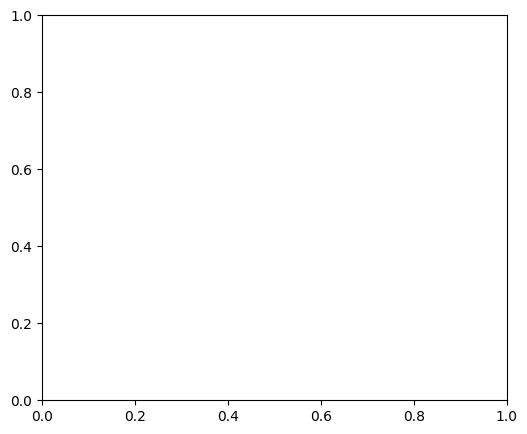

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import shap
import os
from skimage.color import rgb2hsv

# Load images from subfolders
def load_images_from_subfolder(folder):
    images = []
    paths = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        for filename in os.listdir(subfolder_path):
            path = os.path.join(subfolder_path, filename)
            image = Image.open(path).convert("RGB")  # Open image
            image = transform(image)                 # Apply transform
            image = image.view(-1)                   # Flatten
            images.append(image.numpy())
            paths.append(path)
    return np.stack(images), paths

# Extract color and histogram features
def extract_trained_features(image: Image.Image):
    image_np = np.array(image.resize((128, 128))) / 255.0
    mean_rgb = image_np.mean(axis=(0, 1))
    hsv = rgb2hsv(image_np)
    mean_hsv = hsv.mean(axis=(0, 1))
    std_rgb = image_np.std(axis=(0, 1))
    std_hsv = hsv.std(axis=(0, 1))

    # HSV histograms
    h_hist, _ = np.histogram(hsv[:, :, 0], bins=8, range=(0, 1), density=True)
    s_hist, _ = np.histogram(hsv[:, :, 1], bins=8, range=(0, 1), density=True)
    v_hist, _ = np.histogram(hsv[:, :, 2], bins=8, range=(0, 1), density=True)

    return np.concatenate([mean_rgb, std_rgb, mean_hsv, std_hsv, h_hist, s_hist, v_hist])

# Extract features for original images
features_original = np.stack([
    extract_trained_features(Image.open(path).convert('RGB'))
    for path in original_paths
])

# Compute SHAP values
shap_values = explainer.shap_values(features_original)

# Feature labels
feature_names = ['Mean R', 'Mean G', 'Mean B', 'Mean H', 'Mean S', 'Mean V', 'Brightness', 'Contrast']

# SHAP explainer and values
explainer_features = shap.TreeExplainer(model)
shap_values_features = explainer_features.shap_values(features_original)

# Summary plot
shap.summary_plot(shap_values_features, features_original,
                  feature_names=feature_names, max_display=10)

# Dependence plots
for i, name in enumerate(feature_names):
    shap.dependence_plot(name, shap_values_features, features_original,
                         feature_names=feature_names, interaction_index=None)


The model heavily relies on hue (Mean H) and blue/green channels for decisions.

Red channel (Mean R) has minimal impact → Potential to simplify the model by ignoring it.

TRAINING A SPECIAL MODEL FOR SHAP ANALYSIS (on 40 photos) + label smoothing
checking accuracy on smoothed data (not test data) - for avoiding overfitting and 

In [47]:
import os
import numpy as np
from PIL import Image
from skimage.color import rgb2hsv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from sklearn.preprocessing import label_binarize
import shap
import matplotlib.pyplot as plt

# Параметры
IMG_SIZE = 32
num_classes = 4
smoothing = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label smoothing 
def smooth_labels(y, num_classes, smoothing=0.1):
    y_bin = label_binarize(y, classes=list(range(num_classes)))
    return y_bin * (1 - smoothing) + smoothing / num_classes

# CNN Model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=2),  # (64, 64, 64)
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Data Load 
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

label_map = {'autumn': 0, 'spring': 1, 'summer': 2, 'winter': 3}
X = []
y = []
max_per_class = 10

for label, label_id in label_map.items():
    folder = os.path.join('clustered_by_color_type_manually_cleaned_without_augmentation', label)
    class_count = 0
    
    for filename in os.listdir(folder):
        if class_count > max_per_class:
            break
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            try:
                image = Image.open(path).convert("RGB")
                tensor = transform(image)
                X.append(tensor.numpy())
                y.append(label_id)
                class_count += 1
            except Exception as e:
                print(f"Ошибка обработки {filename}: {e}")

X = torch.tensor(np.stack(X), dtype=torch.float32)
y = torch.tensor(smooth_labels(y, num_classes, smoothing), dtype=torch.float32)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Model learning
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        log_probs = F.log_softmax(preds, dim=1)
        loss = -(yb * log_probs).sum(dim=1).mean()  # Label smoothing + cross entropy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred_labels = preds.argmax(dim=1).cpu().numpy()
        true_labels = yb.argmax(dim=1).cpu().numpy()  
        total_correct += (pred_labels == true_labels).sum()
        total_samples += len(xb)
    accuracy = total_correct / total_samples * 100  
    print(f"Epoch {epoch+1}, accuracy: {accuracy:.2f}% loss: {total_loss:.4f}")



Epoch 1, accuracy: 25.00% loss: 54.3835
Epoch 2, accuracy: 25.00% loss: 36.0409
Epoch 3, accuracy: 25.00% loss: 35.9981
Epoch 4, accuracy: 33.33% loss: 34.9696
Epoch 5, accuracy: 46.57% loss: 32.8728
Epoch 6, accuracy: 44.61% loss: 31.6843
Epoch 7, accuracy: 54.41% loss: 29.8480
Epoch 8, accuracy: 61.76% loss: 26.9217
Epoch 9, accuracy: 71.57% loss: 24.2700
Epoch 10, accuracy: 75.98% loss: 21.8286


In [42]:
# SHAP analisys
model.eval()

# prediction function for KernelExplainer
def predict_fn_flattened(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32).view(-1, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        logits = model(x_tensor)
        probs = F.softmax(logits, dim=1)
    return probs.cpu().numpy()

background_flat = X[:3].view(3, -1).numpy()
test_images_flat = X[3:4].view(1, -1).numpy()

explainer = shap.KernelExplainer(predict_fn_flattened, background_flat)
shap_values = explainer.shap_values(test_images_flat, nsamples=100)


  0%|          | 0/1 [00:00<?, ?it/s]

Checking on the 1 photo ( bad image quality = better performance)

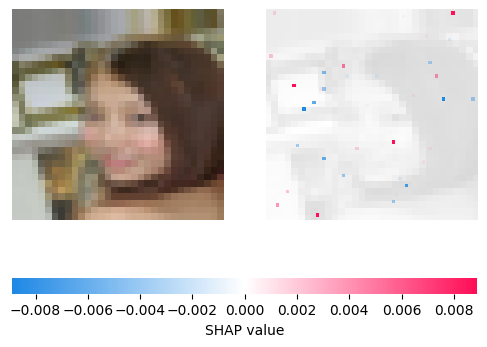

In [43]:
H, W, C = 64, 64, 3 
shap_image = shap_values[0].reshape(1, H, W, C)
images_to_show = X[3:4].permute(0, 2, 3, 1).numpy()

shap.image_plot([shap_image], images_to_show)


In [63]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.preprocessing import label_binarize
import pandas as pd

# === Config ===
IMG_SIZE = 128
num_classes = 4
smoothing = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

label_map = {'autumn': 0, 'spring': 1, 'summer': 2, 'winter': 3}

# === Label smoothing function ===
def smooth_labels(y, num_classes, smoothing=0.1):
    y_bin = label_binarize(y, classes=list(range(num_classes)))
    return y_bin * (1 - smoothing) + smoothing / num_classes

# === Transform for input images ===
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# === Load images and apply transform ===
X = []
y = []
for label, label_id in label_map.items():
    folder = os.path.join('clustered_by_color_type_manually_cleaned_without_augmentation', label)
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder, filename)
            try:
                image = Image.open(path).convert("RGB")
                tensor = transform(image)
                X.append(tensor.numpy())
                y.append(label_id)
            except Exception as e:
                print(f"[ERROR] Failed to process {filename}: {e}")

# === Convert to tensors and apply label smoothing ===
X = torch.tensor(np.stack(X), dtype=torch.float32)
y_smooth = torch.tensor(smooth_labels(y, num_classes, smoothing), dtype=torch.float32)

# === Train/val split ===
X_train, X_val, y_train, y_val = train_test_split(X, y_smooth, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# === Load pretrained ResNet18 and modify classifier ===
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

# === Optimizer ===
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === Training loop ===
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        log_probs = F.log_softmax(preds, dim=1)
        loss = -(yb * log_probs).sum(dim=1).mean()  # cross-entropy with smoothed labels
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Validation ===
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            pred_labels = preds.argmax(dim=1).cpu().numpy()
            true_labels = yb.argmax(dim=1).cpu().numpy()
            val_correct += (pred_labels == true_labels).sum()
            val_total += len(xb)

    val_accuracy = val_correct / val_total * 100
    print(f" Epoch {epoch+1}: Val Accuracy = {val_accuracy:.2f}%, Train Loss = {total_loss:.4f}")


C:\Users\hamza\PycharmProjects\pythonProject13\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hamza\PycharmProjects\pythonProject13\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hamza/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:04<00:00, 11.6MB/s]


Epoch 1, val accuracy: 52.56%, train loss: 113.8819
Epoch 2, val accuracy: 47.44%, train loss: 93.6473
Epoch 3, val accuracy: 42.95%, train loss: 90.3207
Epoch 4, val accuracy: 57.69%, train loss: 83.5524
Epoch 5, val accuracy: 46.15%, train loss: 77.8624
Epoch 6, val accuracy: 50.64%, train loss: 73.7316
Epoch 7, val accuracy: 47.44%, train loss: 66.9757
Epoch 8, val accuracy: 50.64%, train loss: 61.0980
Epoch 9, val accuracy: 50.64%, train loss: 54.5819
Epoch 10, val accuracy: 49.36%, train loss: 45.2684
Epoch 11, val accuracy: 52.56%, train loss: 42.4041
Epoch 12, val accuracy: 53.21%, train loss: 38.8092
Epoch 13, val accuracy: 48.72%, train loss: 37.1557
Epoch 14, val accuracy: 58.33%, train loss: 34.0894
Epoch 15, val accuracy: 51.92%, train loss: 34.9989
Epoch 16, val accuracy: 54.49%, train loss: 31.1539
Epoch 17, val accuracy: 56.41%, train loss: 32.2096
Epoch 18, val accuracy: 48.72%, train loss: 33.5311
Epoch 19, val accuracy: 54.49%, train loss: 34.1099
Epoch 20, val accura

In [5]:
# === Load test data from 'tests' folder and true_labels.csv ===
test_csv_path = os.path.join('true_labels.csv')
df_test = pd.read_csv(test_csv_path)

X_test = []
y_test = []

for idx, row in df_test.iterrows():
    filename = row['filename']
    label_str = row['color_type']
    label_id = label_map.get(label_str)
    if label_id is None:
        print(f"[WARN] Unknown label '{label_str}' in file {filename}")
        continue
    image_path = os.path.join('tests', filename)
    try:
        image = Image.open(image_path).convert("RGB")
        tensor = transform(image)
        X_test.append(tensor.numpy())
        y_test.append(label_id)
    except Exception as e:
        print(f"[ERROR] Failed to process test image {filename}: {e}")

# Convert to tensors
X_test = torch.tensor(np.stack(X_test), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create test loader
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# === Evaluation ===
model.eval()
total_correct = 0
total_samples = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = preds.argmax(dim=1)
        total_correct += (pred_labels == yb).sum().item()
        total_samples += len(xb)

test_accuracy = total_correct / total_samples * 100
print(f" Test accuracy: {test_accuracy:.2f}%")  

# Result: 30%


NameError: name 'pd' is not defined

In [87]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
import collections

# === Parameters ===
IMG_SIZE = 256  # initial resize before cropping
CROP_SIZE = 224
num_classes = 4
BATCH_SIZE = 16
EPOCHS = 40
PATIENCE = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
label_map = {'autumn': 0, 'spring': 1, 'summer': 2, 'winter': 3}

# === Data augmentations ===
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load images and labels from folders ===
def load_dataset(folder_path, transform):
    X, y = [], []
    for label, label_id in label_map.items():
        folder = os.path.join(folder_path, label)
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                try:
                    img = Image.open(os.path.join(folder, filename)).convert("RGB")
                    img_tensor = transform(img)
                    X.append(img_tensor.numpy())
                    y.append(label_id)
                except Exception as e:
                    print(f"[ERROR] Failed to process {filename}: {e}")
    return np.stack(X), np.array(y)

# === Load data and split into train/val sets ===
X_np, y_np = load_dataset('clustered_by_color_type_manually_cleaned_without_augmentation', train_transform)

# === Class balance check ===
print("⚖ Class distribution:")
counts = collections.Counter(y_np)
for label_id, count in counts.items():
    for k, v in label_map.items():
        if v == label_id:
            print(f" - {k}: {count} images")

X_train, X_val, y_train, y_val = train_test_split(X_np, y_np, test_size=0.2, random_state=42)

# === Datasets and loaders ===
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# === Load pre-trained ResNet18 and fine-tune last layers ===
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

# === Loss, optimizer, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# === Training loop with early stopping ===
best_val_loss = 0
early_stop_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Validation phase ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

            pred_labels = preds.argmax(dim=1)
            val_correct += (pred_labels == yb).sum().item()
            val_total += len(xb)

    val_accuracy = val_correct / val_total * 100
    scheduler.step(val_accuracy)

    print(f"📊 Epoch {epoch+1}: Val Accuracy = {val_accuracy:.2f}%, Train Loss = {total_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("✅ Validation loss improved. Model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break



⚖ Распределение классов:
 - autumn: 249 изображений
 - spring: 204 изображений
 - summer: 170 изображений
 - winter: 232 изображений
Epoch 1, val accuracy: 52.05%, train loss: 50.8809, lr: 0.000500
✅ Model improved. Saved.
Epoch 2, val accuracy: 60.23%, train loss: 16.3015, lr: 0.000500
Epoch 3, val accuracy: 64.33%, train loss: 7.3158, lr: 0.000500
✅ Model improved. Saved.
Epoch 4, val accuracy: 63.74%, train loss: 5.0986, lr: 0.000500
Epoch 5, val accuracy: 57.31%, train loss: 5.8245, lr: 0.000500
✅ Model improved. Saved.
Epoch 6, val accuracy: 57.89%, train loss: 5.3340, lr: 0.000500
Epoch 7, val accuracy: 61.40%, train loss: 5.1054, lr: 0.000250
Epoch 8, val accuracy: 61.99%, train loss: 2.9847, lr: 0.000250
Epoch 9, val accuracy: 64.33%, train loss: 1.0245, lr: 0.000250
Epoch 10, val accuracy: 59.65%, train loss: 0.5388, lr: 0.000250
🛑 Early stopping triggered.


In [88]:
# === Load best saved model ===
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# === Load test data from CSV and image folder ===
test_csv_path = os.path.join('true_labels.csv')
df_test = pd.read_csv(test_csv_path)

X_test = []
y_test = []

for idx, row in df_test.iterrows():
    filename = row['filename']
    label_str = row['color_type']
    label_id = label_map.get(label_str)
    if label_id is None:
        print(f"[WARNING] Unknown label '{label_str}' for file {filename}")
        continue

    image_path = os.path.join('tests', filename)
    try:
        image = Image.open(image_path).convert("RGB")
        tensor = val_transform(image)  # Use same transform as in validation
        X_test.append(tensor.numpy())
        y_test.append(label_id)
    except Exception as e:
        print(f"[ERROR] Failed to process {filename}: {e}")

# === Convert test data to tensors ===
X_test = torch.tensor(np.stack(X_test), dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# === Evaluate model on test set ===
total_correct = 0
total_samples = 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = preds.argmax(dim=1)
        total_correct += (pred_labels == yb).sum().item()
        total_samples += len(xb)

test_accuracy = total_correct / total_samples * 100
print(f" Test accuracy: {test_accuracy:.2f}%")


 Test accuracy: 50.57%
